# Network Anomaly Detection Based on Multiclass Classification in UNSW_NB15 Dataset

In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #for categorical data

In [ ]:
df = []
for i in range(1,5):
    path = r'C:\XX.csv'  
    df.append(pd.read_csv(path.format(i), header = None))
data = pd.concat(df).reset_index(drop=True)  # Concat all data file to a single df


In [3]:
data.shape

(2540047, 49)

In [4]:
#within 4 file we have 2540047 row and 49 columns for 49 features like:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [ ]:
#to put feature names to columns:
df_col = pd.read_csv(r'C:\XX.csv', encoding='ISO-8859-1')
#make them lowercase and rmove spaces
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

In [6]:
data.columns = df_col['Name']

In [7]:
data.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload',
       'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object', name='Name')

# Data Preprocessing

In [8]:
#missing values
data.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [9]:
#to find what are attack cattegories
data['attack_cat'].value_counts()

Generic             215481
Exploits             44525
 Fuzzers             19195
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: attack_cat, dtype: int64

In [10]:
#if attack_cat is null then it is 'normal'
data['attack_cat']=data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [11]:
#we see that 'Backdoors' and 'Backdoor' are same, and some of the labels has gap, we need to remove the gaps and combine the labels as a unique
data['attack_cat'] = data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [12]:
# if ct_flw_http_mthd is null , it means number of count zero, so fill them with zero
data['ct_flw_http_mthd'] = data.ct_flw_http_mthd.fillna(value=0)

In [13]:
# is_ftp_login is binary column, check if other value exist
data['is_ftp_login'].value_counts()

0.0    1066593
1.0      43389
4.0        156
2.0         30
Name: is_ftp_login, dtype: int64

In [14]:
#fill null values with zero and convert 2 and 4 to 1 which means ftp login is done
data['is_ftp_login'] = data.is_ftp_login.fillna(value=0)
data['is_ftp_login'] = np.where(data['is_ftp_login']>1, 1, data['is_ftp_login'])

In [15]:
#make 'is_ftp_login' binary by converting it float to integer.
data['is_ftp_login'] = data['is_ftp_login'].astype(int)

In [16]:
#check for null values 
data.isnull().sum().sum()

0

In [17]:
data['service'].value_counts()

-           1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: service, dtype: int64

In [18]:
#there is no service like "-" replace them with none
data['service'] = data['service'].apply(lambda x:"None" if x=="-" else x)
data['service'].value_counts()

None        1246397
dns          781668
http         206273
ftp-data     125783
smtp          81645
ftp           49090
ssh           47160
pop3           1533
dhcp            172
ssl             142
snmp            113
radius           40
irc              31
Name: service, dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

In [20]:
# ct_ftp_cmd is not a categorical data , it is numerical data because it shows number of flows that has a command in ftp session.
# to transform to numerical data;
data['ct_ftp_cmd'].unique()

array([0, 1, 6, 2, 4, 8, 5, 3, '0', '1', ' ', '2', '4'], dtype=object)

In [21]:
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

In [22]:
# to find categorical and numerical features
cat = data.select_dtypes(exclude=np.number).columns.values
num = data.select_dtypes(include=np.number).columns.values

print("categorical features =",cat)

print("numerical features=",num)

categorical features = ['srcip' 'sport' 'dstip' 'dsport' 'proto' 'state' 'service' 'attack_cat']
numerical features= ['dur' 'sbytes' 'dbytes' 'sttl' 'dttl' 'sloss' 'dloss' 'sload' 'dload'
 'spkts' 'dpkts' 'swin' 'dwin' 'stcpb' 'dtcpb' 'smeansz' 'dmeansz'
 'trans_depth' 'res_bdy_len' 'sjit' 'djit' 'stime' 'ltime' 'sintpkt'
 'dintpkt' 'tcprtt' 'synack' 'ackdat' 'is_sm_ips_ports' 'ct_state_ttl'
 'ct_flw_http_mthd' 'is_ftp_login' 'ct_ftp_cmd' 'ct_srv_src' 'ct_srv_dst'
 'ct_dst_ltm' 'ct_src_ltm' 'ct_src_dport_ltm' 'ct_dst_sport_ltm'
 'ct_dst_src_ltm' 'label']


In [23]:
#check for binary columns
for col in 'is_sm_ips_ports', 'is_ftp_login':
    print(data[col].value_counts())
    print()

0    2535852
1       4195
Name: is_sm_ips_ports, dtype: int64

0    2496472
1      43575
Name: is_ftp_login, dtype: int64



In [24]:
#change the data type of "sport" and "dsport" becuase they are port number, so they are not categorical.
#there are some invalid port numbers in sport, replace them first with zero to convert it to integer.
data['sport'] = data['sport'].replace(to_replace='-',value='0')
data['sport'] = data['sport'].replace(to_replace='0x000b',value='0')
data['sport'] = data['sport'].replace(to_replace='0x000c',value='0')


In [25]:
data['sport'] = data['sport'].astype(int)

In [26]:
data['dsport'] = data['sport'].replace(to_replace='-',value='0')

In [27]:
data['dsport'] = data['dsport'].astype(int)

In [28]:
#change datatype of 'ct_flw_http_mthd' because it is number of flows that has methods such as Get and Post in http service, it is integer.
data['ct_flw_http_mthd'] = data['ct_flw_http_mthd'].astype(int)

In [29]:
#stime and ltime is a timestamp, but in dataset it is given as integer, so we do nothing for now.
data['ltime'].head(5)

0    1421927414
1    1421927414
2    1421927414
3    1421927414
4    1421927414
Name: ltime, dtype: int64

In [30]:
data.dtypes.value_counts()

int64      28
float64    10
object      6
int32       5
dtype: int64


Categorical columns: 'proto', 'service', 'state', 'srcip', 'dstip'

binary: 'is_sm_ips_ports', 'is_ftp_login'

Numerical columns : 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst'

Target columns: 'attack_cat', 'label'

### SAMPLING

In [31]:
data['attack_cat'].value_counts()

normal            2218764
generic            215481
exploits            44525
fuzzers             24246
dos                 16353
reconnaissance      13987
analysis             2677
backdoor             2329
shellcode            1511
worms                 174
Name: attack_cat, dtype: int64

In [32]:
#Stratified Sampling Using Counts -> undersampling
#data = data.groupby('attack_cat', group_keys=False).apply(lambda x: x.sample(174))

In [33]:
#Stratified Sampling Using Proportions
#define total sample size desired
N = 700000

#perform stratified random sampling
data=data.groupby('attack_cat', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(data))))).sample(frac=1).reset_index(drop=True)


### Class Distribution

In [34]:
# Standardizing the numerical columns
scaler = StandardScaler()
scaler = scaler.fit(data[num])
data[num] = scaler.transform(data[num])
data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.5,27222,149.171.126.8,27222,tcp,FIN,-0.031257,0.005588,0.220784,-0.425964,...,-0.110907,-0.572820,-0.368833,-0.544421,-0.475575,-0.429808,-0.419941,-0.519401,normal,-0.380530
1,149.171.126.14,1043,175.45.176.1,1043,udp,INT,-0.042967,-0.079298,-0.229316,-0.037386,...,-0.110907,3.210888,3.235427,2.029392,1.962646,2.166607,3.140948,3.300393,normal,-0.380530
2,59.166.0.3,45819,149.171.126.2,45819,udp,CON,-0.042897,-0.081952,-0.228302,-0.425964,...,-0.110907,-0.388249,-0.646084,-0.544421,0.012069,-0.429808,-0.419941,-0.519401,normal,-0.380530
3,175.45.176.3,47439,149.171.126.18,47439,udp,INT,-0.042967,-0.082269,-0.229316,2.562070,...,-0.110907,3.118602,3.143010,4.480643,4.400868,4.526984,2.331655,3.211561,generic,2.627916
4,59.166.0.8,35431,149.171.126.3,35431,tcp,FIN,-0.019892,0.653782,-0.208168,-0.425964,...,-0.110907,-0.757392,-0.738501,-0.544421,-0.597486,-0.429808,-0.419941,-0.519401,normal,-0.380530


In [35]:
data['attack_cat'].nunique()

10

In [36]:
class_dist = data['attack_cat'].value_counts()/ len(data.index)

print(class_dist)

normal            0.873513
generic           0.084833
exploits          0.017529
fuzzers           0.009546
dos               0.006439
reconnaissance    0.005507
analysis          0.001054
backdoor          0.000917
shellcode         0.000594
worms             0.000069
Name: attack_cat, dtype: float64


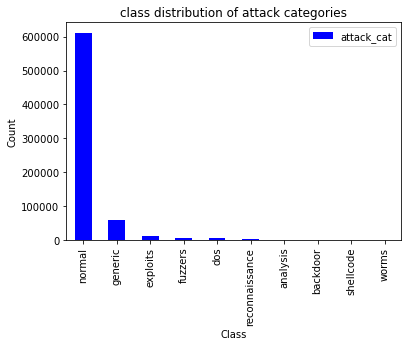

In [37]:
# Plotting target label distribution
plt.figure()
plt.title("class distribution of attack categories")
data['attack_cat'].value_counts().plot(kind="bar", color='b', label="attack_cat")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

#### it is seen that in attack category most of the instances are in 'normal', it means there is a class imbalance problem.

### FEATURE ENGINEERING

In [38]:
data_corr = data.select_dtypes(include=[np.number])
data_corr.shape #we already now that we have 43 numerical data

(700000, 43)

<AxesSubplot:xlabel='Name', ylabel='Name'>

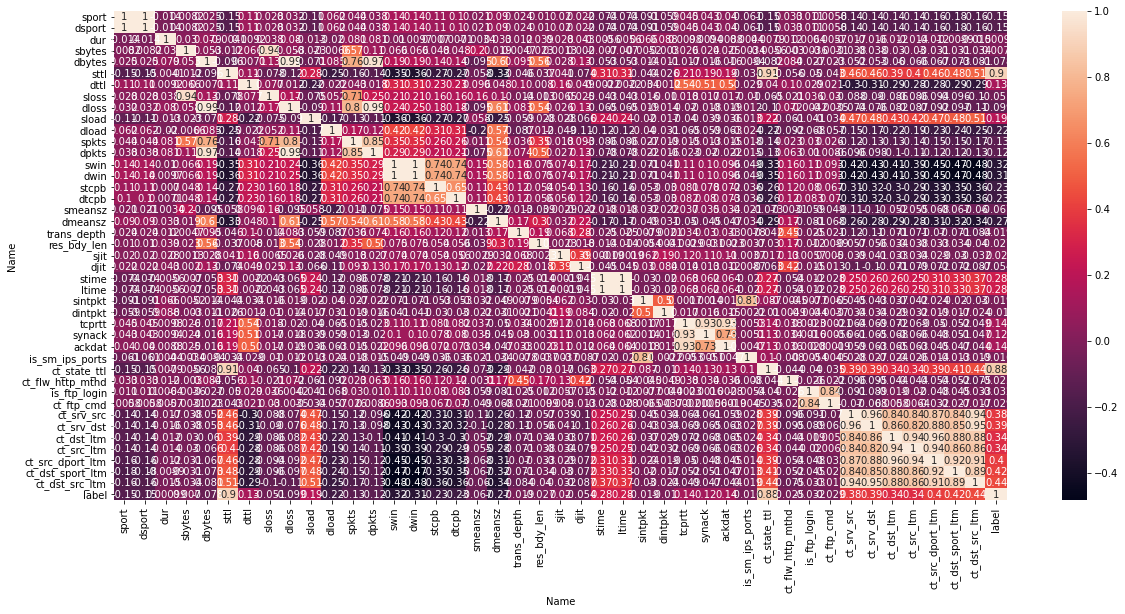

In [39]:
import seaborn as sns
corr = data_corr.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot=True)

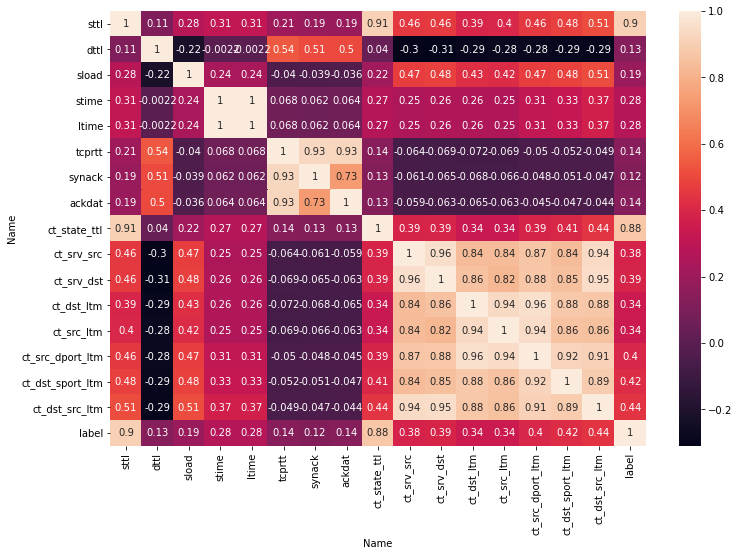

In [40]:
#to find positive correlated features we may use label which shows there is attack or no attack.
top_feature = corr.index[abs(corr['label']>0.1)]
plt.subplots(figsize=(12, 8))
top_corr = data[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

In [41]:
corr = data.corr()
corr.sort_values(['label'], ascending=False, inplace=True)
corr.label

Name
label               1.000000
sttl                0.904259
ct_state_ttl        0.875316
ct_dst_src_ltm      0.440037
ct_dst_sport_ltm    0.419234
ct_src_dport_ltm    0.397769
ct_srv_dst          0.386746
ct_srv_src          0.383171
ct_src_ltm          0.344506
ct_dst_ltm          0.340374
ltime               0.275965
stime               0.275965
sload               0.191992
tcprtt              0.136477
ackdat              0.135280
dttl                0.133692
synack              0.119033
sjit                0.020056
sbytes              0.006953
dur                 0.000988
dintpkt            -0.010498
is_sm_ips_ports    -0.015577
sintpkt            -0.019055
trans_depth        -0.019467
ct_flw_http_mthd   -0.025475
res_bdy_len        -0.027289
ct_ftp_cmd         -0.028863
is_ftp_login       -0.031816
sloss              -0.051376
djit               -0.053560
smeansz            -0.066578
dbytes             -0.077943
dloss              -0.098622
dpkts              -0.118912
spkts    

In [42]:
#network bytes = sbytes(source to destination bytes) plus dbytes(destination to source bytes)
data['nw_bytes'] = data['sbytes'] + data['dbytes']

In [43]:
data=data.drop(["sbytes","dbytes"], axis=1) 

In [44]:
data=data.drop(["swin","dwin"], axis=1) 

In [45]:
#srcip and dsip are IP numbers and not usefull feature for classification because it has unique values, if any new instance comes with different IP address it doesn't affect attacks
data=data.drop(["srcip","dstip"],axis =1)

In [46]:
data.shape

(700000, 44)

In [47]:
data=data.drop(["sport","dsport","dloss","sloss","dload","stcpb","dtcpb","dmeansz"], axis=1) 

In [48]:
data=data.drop(["label"], axis=1) 

In [49]:
#cols = ('srcip','sport', 'dstip', 'dsport', 'proto', 'state', 'service', 'attack_cat')
cols = ('proto', 'state', 'service', 'attack_cat')

In [50]:
#encode
from sklearn.preprocessing import LabelEncoder
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

In [51]:
ac_encoded=lbl.fit_transform(data['attack_cat'])

In [52]:
print(data.attack_cat)

0         6
1         6
2         6
3         5
4         6
         ..
699995    6
699996    6
699997    6
699998    6
699999    6
Name: attack_cat, Length: 700000, dtype: int32


In [53]:
print(num)

['dur' 'sbytes' 'dbytes' 'sttl' 'dttl' 'sloss' 'dloss' 'sload' 'dload'
 'spkts' 'dpkts' 'swin' 'dwin' 'stcpb' 'dtcpb' 'smeansz' 'dmeansz'
 'trans_depth' 'res_bdy_len' 'sjit' 'djit' 'stime' 'ltime' 'sintpkt'
 'dintpkt' 'tcprtt' 'synack' 'ackdat' 'is_sm_ips_ports' 'ct_state_ttl'
 'ct_flw_http_mthd' 'is_ftp_login' 'ct_ftp_cmd' 'ct_srv_src' 'ct_srv_dst'
 'ct_dst_ltm' 'ct_src_ltm' 'ct_src_dport_ltm' 'ct_dst_sport_ltm'
 'ct_dst_src_ltm' 'label']


In [54]:
data.shape

(700000, 35)

#### Split Data

In [55]:
y = data['attack_cat']

In [56]:
del data['attack_cat']

In [57]:
X = data.values
y = y.values

In [58]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) 

### PCA

In [59]:
from sklearn.decomposition import PCA

In [60]:
pca= PCA(15)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
np.cumsum(pca.explained_variance_ratio_)

array([0.69926566, 0.76043979, 0.80945317, 0.83904116, 0.86492039,
       0.87973988, 0.89392927, 0.90720325, 0.91911672, 0.92877381,
       0.93794313, 0.94671058, 0.95505991, 0.9611287 , 0.96704753])

In [61]:
exp_var_pca= pca.explained_variance_ratio_

In [62]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

In [63]:
print(cum_sum_eigenvalues)

[0.69926566 0.76043979 0.80945317 0.83904116 0.86492039 0.87973988
 0.89392927 0.90720325 0.91911672 0.92877381 0.93794313 0.94671058
 0.95505991 0.9611287  0.96704753]


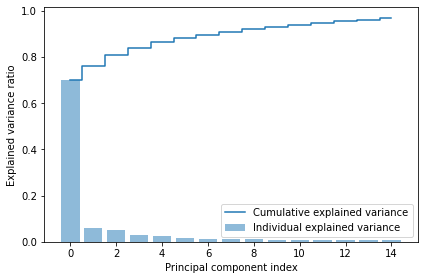

In [64]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### CLASSIFICATION

In [65]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=13)

#Train the model using training sets
knn.fit(X_train, y_train)

#Predict 
y_pred = knn.predict(X_test)

In [66]:
from sklearn import metrics
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100)

Accuracy: 97.48857142857142


In [67]:
from sklearn.model_selection import KFold

In [68]:
from sklearn.model_selection import cross_val_score

In [69]:
clf = KNeighborsClassifier(n_neighbors=10)
>>> scores = cross_val_score(clf, X, y, cv=5)
>>> scores

array([0.97422857, 0.97431429, 0.97431429, 0.97459286, 0.97447143])

In [70]:
print(scores.mean())


0.9743842857142857


In [71]:
from sklearn.model_selection import GridSearchCV

#define the model and parameters
knn = KNeighborsClassifier()

parameters = {'n_neighbors':[5,10,11,12,13,14,15,20]}

#Fit the model
model = GridSearchCV(knn, param_grid=parameters)
model.fit(X_train,y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 11, 12, 13, 14, 15, 20]})

In [72]:
print(model.best_params_)

{'n_neighbors': 15}


In [73]:
accuracy = model.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 97.47%


In [74]:
from sklearn.neighbors import NearestCentroid

In [75]:
model = NearestCentroid()
 
# Training the classifier
model.fit(X_train, y_train.ravel())
 
# Printing Accuracy on Training and Test sets
print(f"Training Set Score : {model.score(X_train, y_train) * 100} %")
print(f"Test Set Score : {model.score(X_test, y_test) * 100} %")

Training Set Score : 85.78267857142858 %
Test Set Score : 85.82142857142857 %
